In [89]:
from feature_engineering import generate_features
from get_data import get_raw_data
import pandas as pd
from feature_engineering import get_sp_500_data

In [92]:
data=generate_features(get_raw_data('AMZN'))
overall_market_data=get_sp_500_data(get_raw_data('VOO'))
data=pd.merge(data,overall_market_data,on='Date')

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [93]:
data.head(-10)


,open,open_1,close_1,high_1,low_1,volume_1,avg_price_5,avg_price_30,avg_price_365,ratio_avg_price_5_30,...,moving_avg_30,moving_avg_365,close,open_market,open_1_market,close_1_market,high_1_market,low_1_market,volume_1_market,close_market
Date,,,,,,,,,,,,,,,,,,,,,
2021-09-10,175.091507,176.300995,174.207993,177.499496,174.018494,54384000.0,174.601196,167.589024,163.309303,1.041841,...,-0.052179,0.519611,173.457504,414.690002,414.339996,412.769989,416.070007,412.570007,3887800.0,409.579987
2021-09-13,174.139999,175.091507,173.457504,175.422501,173.145493,47946000.0,174.661496,168.010548,163.367645,1.039586,...,-0.044740,0.516716,172.858505,412.519989,414.690002,409.579987,415.100006,409.420013,4035500.0,410.540009
2021-09-14,173.777496,174.139999,172.858505,174.897995,171.899994,51380000.0,174.452698,168.376429,163.435294,1.036087,...,-0.037190,0.514140,172.500000,412.019989,412.519989,410.540009,412.709991,408.309998,4738300.0,408.410004
2021-09-15,172.126007,173.777496,172.500000,174.340500,171.885498,38738000.0,173.859799,168.747929,163.504149,1.030293,...,-0.030084,0.511835,173.789505,408.790009,412.019989,408.410004,412.179993,407.489990,3657700.0,411.820007
2021-09-16,172.998001,172.126007,173.789505,174.270996,170.100494,59150000.0,173.362701,169.168882,163.567573,1.024791,...,-0.023406,0.509553,174.412003,411.269989,408.790009,411.820007,412.260010,407.700012,3891400.0,411.109985
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-29,173.009995,172.440002,173.160004,174.050003,172.270004,28180500.0,174.200000,169.405236,131.496508,1.028304,...,0.105295,0.178557,176.759995,466.970001,464.489990,465.209991,465.829987,464.109985,2800600.0,466.929993
2024-03-01,176.750000,173.009995,176.759995,177.220001,172.850006,53805400.0,174.635999,170.250950,131.824008,1.025756,...,0.106349,0.183428,178.220001,467.829987,466.970001,466.929993,468.489990,464.470001,7332900.0,471.429993
2024-03-04,177.529999,176.750000,178.220001,178.729996,176.070007,31956200.0,175.281998,171.347141,132.165476,1.022964,...,0.109923,0.188440,177.580002,470.609985,467.829987,471.429993,471.769989,467.429993,4833700.0,470.869995


In [94]:
data.shape

(635, 45)

In [95]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from keras.models import Sequential
from keras.layers import  LSTM, Dense,Dropout


In [96]:
# here we are seperating the data 
trainning_set = data[:'2024-02-01'].iloc[:,1:2].values
test_set = data['2024-02-01':].iloc[:,1:2].values

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
training_set_scaled = scaler.fit_transform(trainning_set)


X_train = []
Y_train = []


for i in range(1, len(training_set_scaled)):
    X_train.append(training_set_scaled[i-1:i, 0])
    Y_train.append(training_set_scaled[i, 0])

# Convert lists to NumPy arrays
X_train, y_train = np.array(X_train), np.array(Y_train)

# Reshape X_train for LSTM input shape (batch_size, timesteps, input_dim)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [97]:
X_train.shape

(601, 1, 1)

In [98]:

# pre-processing the data 
dataset_total = pd.concat((data["close"][:'2024-02-01'],data["close"]['2024-02-01':]),axis=0)
inputs = dataset_total[len(dataset_total)-len(test_set) - 500:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

# making the test data
X_test = []
for i in range(500,len(inputs)):
  X_test.append(inputs[i-1:i,0])

X_test_no_shape = np.array(X_test)
X_test = np.reshape(X_test_no_shape, (X_test_no_shape.shape[0],X_test_no_shape.shape[1],1))


test_set=scaler.transform(test_set)

In [99]:
print(test_set)

[[0.72154768]
 [0.7105591 ]
 [0.84008768]
 [0.84990923]
 [0.84203252]
 [0.84290768]
 [0.84456081]
 [0.85671626]
 [0.89464136]
 [0.82589005]
 [0.84028221]
 [0.85360454]
 [0.83571175]
 [0.82686254]
 [0.83765659]
 [0.87810998]
 [0.88958465]
 [0.90339323]
 [0.88763981]
 [0.87169186]
 [0.87723467]
 [0.91360384]
 [0.92118883]
 [0.91535415]
 [0.9018373 ]
 [0.89493308]
 [0.91058931]
 [0.88987637]
 [0.88199966]
 [0.90533807]
 [0.92274476]
 [0.91253415]
 [0.90436572]
 [0.88900121]]


In [81]:
from tensorboard.plugins.hparams import api as hp

In [100]:
def mae(y_predicted, y_true):
    total_error = 0
    for yp, yt in zip(y_predicted, y_true):
        total_error += abs(yp - yt)
    
    mae = total_error/len(y_predicted)
    
    return mae

In [12]:
import tensorflow as tf
from tensorboard.plugins.hparams import api as hp

HP_NUM_UNITS_1 = hp.HParam('num_units_1', hp.Discrete([64, 128]))
HP_NUM_UNITS_2 = hp.HParam('num_units_2', hp.Discrete([64, 128]))
HP_NUM_UNITS_3 = hp.HParam('num_units_3', hp.Discrete([32, 64]))
HP_NUM_UNITS_4 = hp.HParam('num_units_4', hp.Discrete([32, 64]))
HP_DROPOUT_1 = hp.HParam('dropout_1', hp.RealInterval(0.1,0.2))
HP_DROPOUT_2 = hp.HParam('dropout_2', hp.RealInterval(0.1, 0.2))


METRIC_MAE = 'mean_absolute_error'


with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
  hp.hparams_config(
    hparams=[HP_NUM_UNITS_1, HP_NUM_UNITS_2, HP_NUM_UNITS_3, HP_NUM_UNITS_4, HP_DROPOUT_1, HP_DROPOUT_2],
     metrics=[hp.Metric(METRIC_MAE, display_name='mean_absolute_error')]
    )  


In [82]:
def train_test_model(hparams):
  
  model = Sequential()

  model.add(LSTM(units=hparams[HP_NUM_UNITS_1], return_sequences=True, input_shape=(X_train.shape[1], 1)))
  model.add(Dropout(hparams[HP_DROPOUT_1]))

  model.add(LSTM(units=hparams[HP_NUM_UNITS_2], return_sequences=True))
  model.add(Dropout(hparams[HP_DROPOUT_2]))

  model.add(LSTM(units=hparams[HP_NUM_UNITS_3]))
  model.add(Dropout(0.1))

  model.add(Dense(units=hparams[HP_NUM_UNITS_4]))
  model.add(Dropout(0.1))

  model.add(Dense(units=1))
                         
  model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
  loss='mae', metrics=['mae'])
  
  callback = keras.callbacks.EarlyStopping(
    monitor='loss',
    patience=10,
    restore_best_weights=True)

  model.fit(X_train, y_train, epochs=25,batch_size=32,callbacks=[callback]) # Run with 1 epoch to speed things up for demo purposes
  loss = model.evaluate(X_test, test_set)[0]  
  
  return loss
  
  

In [83]:
def run(run_dir, hparams):
    with tf.summary.create_file_writer(run_dir).as_default():
        hp.hparams(hparams) 
        loss = train_test_model(hparams)  
        tf.summary.scalar('mean_absolute_error', loss, step=1)
       


rm -rf ./logs/ clean logs


In [84]:
session_num = 0

for num_units_1 in HP_NUM_UNITS_1.domain.values:
    for num_units_2 in HP_NUM_UNITS_2.domain.values:
        for num_units_3 in HP_NUM_UNITS_3.domain.values:
            for num_units_4 in HP_NUM_UNITS_4.domain.values:
                for dropout_rate_1 in (HP_DROPOUT_1.domain.min_value, HP_DROPOUT_1.domain.max_value):
                    for dropout_rate_2 in (HP_DROPOUT_2.domain.min_value, HP_DROPOUT_2.domain.max_value):
                                hparams = {
                                    HP_NUM_UNITS_1: num_units_1,
                                    HP_NUM_UNITS_2: num_units_2,
                                    HP_NUM_UNITS_3: num_units_3,
                                    HP_NUM_UNITS_4: num_units_4,
                                    HP_DROPOUT_1: dropout_rate_1,
                                    HP_DROPOUT_2: dropout_rate_2,
                                }
                                run_name = "run-%d" % session_num
                                print('--- Starting trial: %s' % run_name)
                                print({h.name: hparams[h] for h in hparams})
                                run('logs/hparam_tuning3/' + run_name, hparams)
                                session_num += 1



--- Starting trial: run-0
{'num_units_1': 64, 'num_units_2': 64, 'num_units_3': 32, 'num_units_4': 32, 'dropout_1': 0.1, 'dropout_2': 0.1}
Epoch 1/25
19/19 [==============================] - 3s 3ms/step - loss: 0.2468 - mae: 0.2468
Epoch 2/25
19/19 [==============================] - 0s 3ms/step - loss: 0.1780 - mae: 0.1780
Epoch 3/25
19/19 [==============================] - 0s 4ms/step - loss: 0.1289 - mae: 0.1289
Epoch 4/25
19/19 [==============================] - 0s 4ms/step - loss: 0.0420 - mae: 0.0420
Epoch 5/25
19/19 [==============================] - 0s 3ms/step - loss: 0.0369 - mae: 0.0369
Epoch 6/25
19/19 [==============================] - 0s 3ms/step - loss: 0.0353 - mae: 0.0353
Epoch 7/25
19/19 [==============================] - 0s 5ms/step - loss: 0.0336 - mae: 0.0336
Epoch 8/25
19/19 [==============================] - 0s 4ms/step - loss: 0.0316 - mae: 0.0316
Epoch 9/25
19/19 [==============================] - 0s 3ms/step - loss: 0.0327 - mae: 0.0327
Epoch 10/25
19/19 [=====

KeyboardInterrupt: 

Best h-params : DROP [0.3,0.1,0.1,0.1] UNITS[32,32,64,32]

In [101]:
model = Sequential()

model.add(LSTM(units=128, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(Dropout(0.3))

model.add(LSTM(units=128,return_sequences=True))
model.add(Dropout(0.1))

model.add(LSTM(units=65))
model.add(Dropout(0.3))

model.add(Dense(units=32))
model.add(Dropout(0.1))

model.add(Dense(units=1))
                        
model.compile(loss='mean_squared_error',optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

callback = keras.callbacks.EarlyStopping(
    monitor='loss',
    patience=10,
    restore_best_weights=True)

model.fit(X_train, y_train, epochs=100,batch_size=32,callbacks=[callback]) 
loss = model.evaluate(X_test, test_set)

Epoch 1/100
19/19 [==============================] - 4s 5ms/step - loss: 0.1624
Epoch 2/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0433
Epoch 3/100
19/19 [==============================] - 0s 6ms/step - loss: 0.0313
Epoch 4/100
19/19 [==============================] - 0s 6ms/step - loss: 0.0117
Epoch 5/100
19/19 [==============================] - 0s 7ms/step - loss: 0.0065
Epoch 6/100
19/19 [==============================] - 0s 6ms/step - loss: 0.0045
Epoch 7/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0054
Epoch 8/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0047
Epoch 9/100
19/19 [==============================] - 0s 6ms/step - loss: 0.0047
Epoch 10/100
19/19 [==============================] - 0s 6ms/step - loss: 0.0049
Epoch 11/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0040
Epoch 12/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0046
Epoch 13/100
19/19 [=================

In [102]:
predicted_stock_price = model.predict(X_test)
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)
test_set=scaler.inverse_transform(test_set)

2/2 [==============================] - 1s 8ms/step


In [103]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score

print(f"MSE: {mean_squared_error(test_set,predicted_stock_price)}")
print(f"MRSE: {mean_absolute_error(test_set,predicted_stock_price)}")
print(f"R^2: {r2_score(test_set,predicted_stock_price)}")

MSE: 4.817420437418417
MRSE: 1.7852913351619946
R^2: 0.8023912007816661


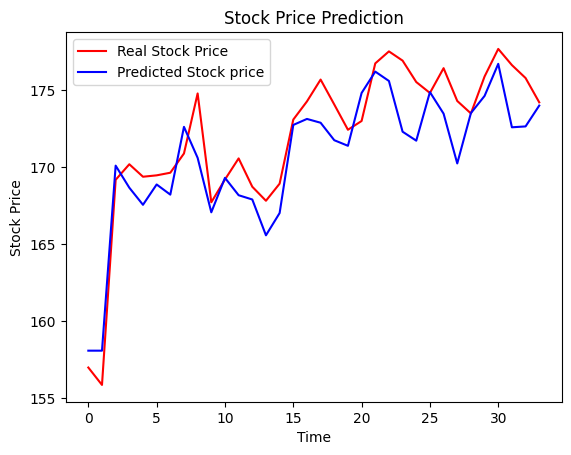

In [104]:
import matplotlib.pyplot as plt

def plot_prediction(test,prediction):
    plt.plot(test,color='red',label="Real Stock Price")
    plt.plot(prediction, color="blue",label="Predicted Stock price")
    plt.title("Stock Price Prediction")
    plt.xlabel("Time")
    plt.ylabel("Stock Price")
    plt.legend()
    plt.show()


plot_prediction(test_set,predicted_stock_price)